# Elo Merchant Category Recommendation(预测用户忠诚度)

## EDA_数据探索

In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
# train.csv：训练集。
# test.csv：测试集。
# sample_submission.csv：正确与规范的提交文件示例，含有需要参赛者预测的所有的 card_id。
# historical_transactions.csv：信用卡（card_id）在给定商家的历史交易记录，对于每张信用卡，最多包含其三个月的交易记录。
# merchants.csv：数据集中所有商家（商家 id）的附加信息。
# new_merchant_transactions.csv：每张信用卡在新商家的购物数据，最多包含两个月的数据。
train = pd.read_csv('data/train.csv')
test =  pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
print(train.shape, test.shape, submission.shape)

(201917, 6) (123623, 5) (123623, 2)


In [60]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [61]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [62]:
submission.head()

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0


In [63]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [64]:
test.isnull().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

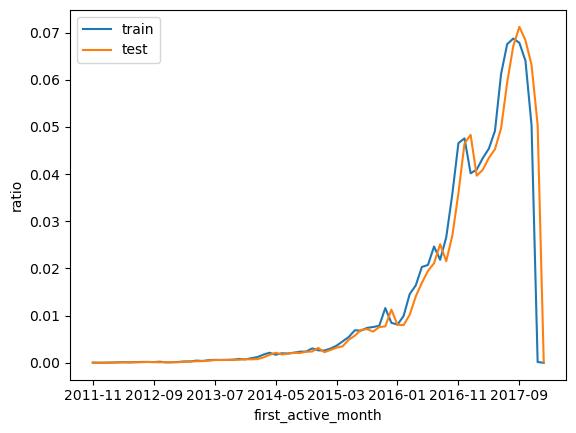

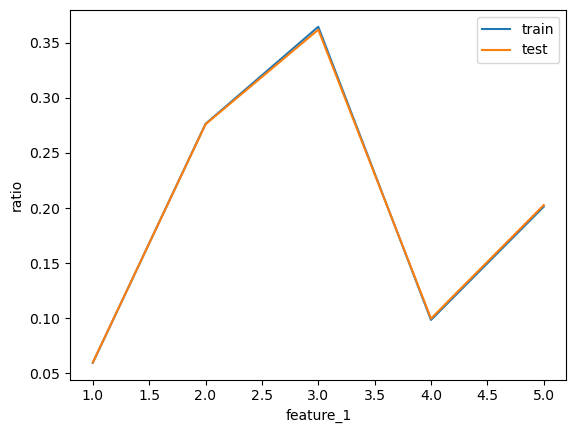

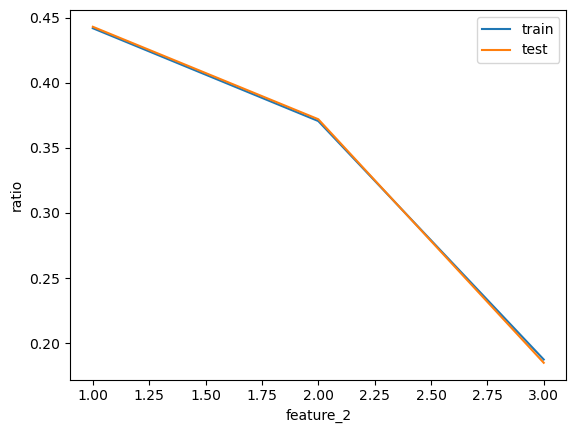

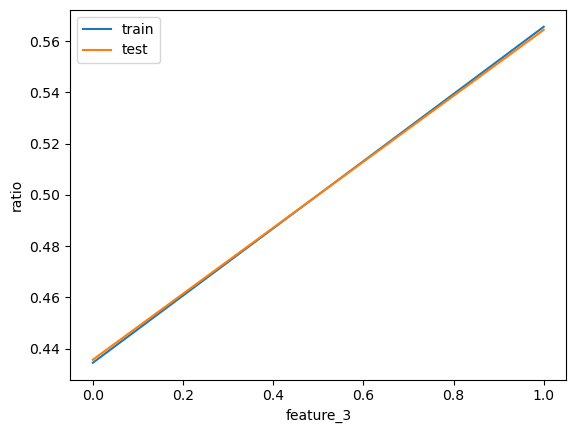

In [65]:
# 以first_active_month为例分析训练集与测试集的差异
features = ['first_active_month','feature_1','feature_2','feature_3']
train_count = train.shape[0]
test_count = test.shape[0]
for feature in features:
    (train[feature].value_counts().sort_index()/train_count).plot()
    (test[feature].value_counts().sort_index()/test_count).plot()
    plt.legend(['train','test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()

In [66]:
# 目标的范围
train['target'].describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [67]:
merchant = pd.read_csv('data/merchants.csv')
merchant.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [68]:
# 根据商家信息表字段的离散和连续属性，参赛者可将两类字段分开后统一化分析，现字段分离如下
category_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'category_4', 'city_id', 'state_id', 'category_2']
numeric_cols = ['numerical_1', 'numerical_2',
     'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']

In [69]:
merchant[category_cols].dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [70]:
merchant[category_cols].nunique()

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

In [71]:
merchant['category_1'].unique()

array(['N', 'Y'], dtype=object)

In [72]:
# 对类型型变量进行编码(序数编码)
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value)), index=value)).values
for col in ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']:
    merchant[col] = change_object_cols(merchant[col])

In [73]:
# 同时为了能够更方便统计，首先做缺失值处理，对离散字段可统一用-1进行填充
merchant[category_cols].isnull().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [74]:
merchant[category_cols] = merchant[category_cols].fillna(-1)

In [75]:
merchant[numeric_cols].describe()

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334696.000000,334696.000000,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000
mean,0.011476,0.008103,13.832993,inf,2.994108,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335
std,1.098154,1.070497,2395.489999,NaN,0.095247,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138
min,-0.057471,-0.057471,-82.130000,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000
25%,-0.057471,-0.057471,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000
50%,-0.057471,-0.057471,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000
75%,-0.047556,-0.047556,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000
max,183.735111,182.079322,851844.640000,inf,3.000000,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000


In [79]:
inf_cols = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']
merchant[inf_cols] = merchant[inf_cols].replace(np.inf, merchant[inf_cols].replace(np.inf, -99).max())

In [80]:
# 基于baseline填充数字类型平均值
for col in numeric_cols:
    merchant[col] = merchant[col].fillna(merchant[col].mean())

In [83]:
new_transaction = pd.read_csv('data/new_merchant_transactions.csv')

In [85]:
history_transaction = pd.read_csv('data/historical_transactions.csv')

In [87]:
#基于类型对col进行分类
numeric_cols = [ 'installments', 'month_lag', 'purchase_amount']
category_cols = ['authorized_flag', 'card_id', 'city_id', 'category_1',
       'category_3', 'merchant_category_id', 'merchant_id', 'category_2', 'state_id',
       'subsector_id']
time_cols = ['purchase_date']

In [92]:
for col in ['authorized_flag', 'category_1', 'category_3']:
    new_transaction[col] = change_object_cols(new_transaction[col].fillna(-1).astype(str))
new_transaction[category_cols] = new_transaction[category_cols].fillna(-1)


In [94]:
# 由于两张交易表是根据信用卡用户消费的时间来进行区分，因此有必要着重分析这二者之间的区别与联系
print(new_transaction['month_lag'].describe())
print(new_transaction['purchase_date'].min(), 'to', new_transaction['purchase_date'].max())

count    1.963031e+06
mean     1.476515e+00
std      4.994483e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: month_lag, dtype: float64


2017-03-01 03:24:51 to 2018-04-30 23:59:59


In [95]:
print(history_transaction['month_lag'].describe())
print(history_transaction['purchase_date'].min(), 'to', history_transaction['purchase_date'].max())

count    2.911236e+07
mean    -4.487294e+00
std      3.588800e+00
min     -1.300000e+01
25%     -7.000000e+00
50%     -4.000000e+00
75%     -2.000000e+00
max      0.000000e+00
Name: month_lag, dtype: float64


2017-01-01 00:00:08 to 2018-02-28 23:59:51


In [106]:
history_transaction['purchase_date']

0           2017-06-25 15:33:07
1           2017-07-15 12:10:45
2           2017-08-09 22:04:29
3           2017-09-02 10:06:26
4           2017-03-10 01:14:19
                   ...         
29112356    2017-01-20 08:52:04
29112357    2017-02-20 04:40:50
29112358    2017-12-26 18:37:51
29112359    2017-11-24 14:18:15
29112360    2017-10-26 14:09:40
Name: purchase_date, Length: 29112361, dtype: object

In [99]:
history_transaction[history_transaction['month_lag']==0]['purchase_date'].apply(lambda x:'-'.join(x.split(' ')[0].split('-')[:2])).value_counts()

2018-02    2430964
2018-01     254374
2017-12     206195
2017-11     118028
2017-10      82104
2017-09      80317
2017-08      66144
2017-07      59202
2017-06      49514
2017-05      43101
2017-04      40939
2017-03      36822
2017-02       3242
Name: purchase_date, dtype: int64

In [100]:
#结论：由上面可知month_lag是一个相对值，每个信用卡id的month_lag=0的月份都不一样，即用户最新一次购物的时间不一样
#显然越是出现在最新日期的用户越有可能粘性越强价值越高，也就是题目所衡量的越忠诚

# 5.目标列相关指标分析

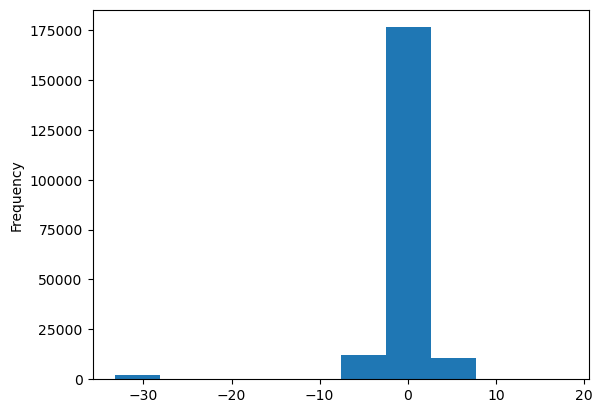

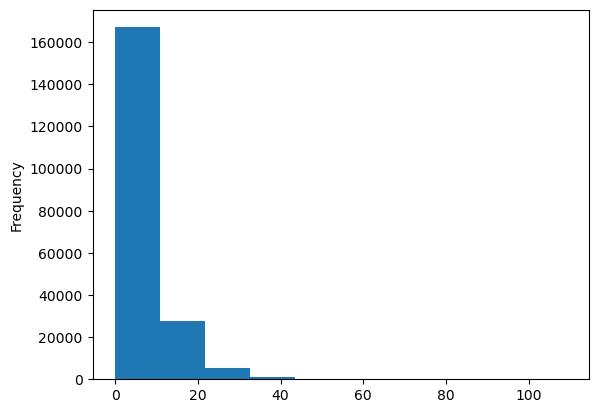

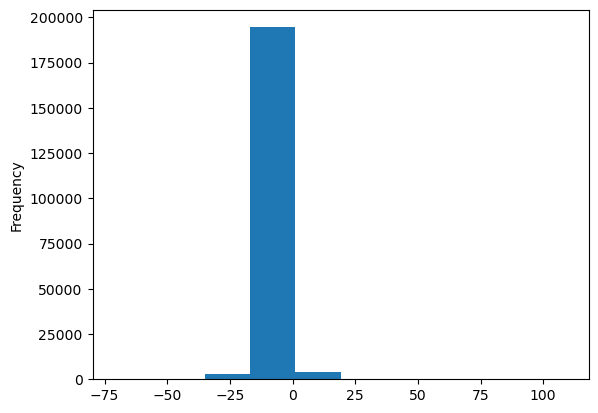

In [101]:
# 在熟悉基本比赛数据后，直觉上参赛者可考虑使用RFM分析，即采用recent、frequency、money进行
# 目标列相关性分析,简单起见，这里以new_transaction为例，由于都是最近记录因此就不统计recent
card_rfm = train[['card_id', 'target']].copy()

card_rfm['frequency'] = card_rfm['card_id'].map(new_transaction['card_id'].value_counts()).fillna(0).values
card_rfm['money'] = card_rfm['card_id'].map(new_transaction.groupby('card_id')['purchase_amount'].sum()).fillna(0).values

card_rfm = card_rfm.sort_values('target').reset_index(drop=True)
for col in ['target', 'frequency', 'money']:
    card_rfm[col].plot.hist()
    plt.show()
    
# 结论：可以看出，target高的用户集中在频次与消费都高的区域，这个发现也比较符合逻辑